In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:


# import some data to play with
iris = datasets.load_iris()

cols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
data=iris.data
target=iris.target
target_classes=iris.target_names.tolist()
mapping=dict(enumerate(target_classes))
consolidated=pd.concat([pd.DataFrame(data,columns=cols[:-1]),pd.DataFrame(target,columns=[cols[-1]])],axis=1)
consolidated

,sepal_length,sepal_width,petal_length,petal_width,type
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


Text(0, 0.5, 'Sepal width')

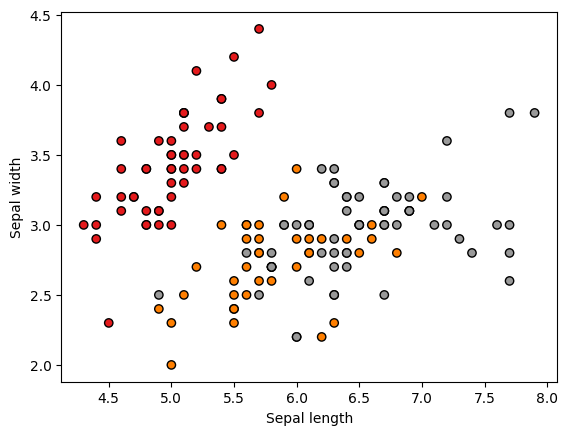

In [3]:
plt.scatter(data[:, 0], data[:, 1], c=target, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

In [4]:
class Node():
    
    __slots__='feature_index','threshold','left','right','information_gain','value'
    
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
     
        
        
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.information_gain = info_gain
        self.value = value


In [25]:
class _DecisionTreeClassifier:
    
    __slots__='min_samples_for_split','max_depth','root','feature_indices'
    
    def __init__(self, min_samples=5, max_depth=3):
        
        self.root = None
        self.min_samples_for_split = min_samples
        self.max_depth = max_depth
        self.feature_indices=[]
    #Defining Gini impurity/index
    def gini_index(self,y):
        y=list(map(int,y))
        
        classes=list(np.unique(y))
        total=len(y) 
        gini_val=0.0
        for clss in range(len(list(np.bincount(y)))):
            gini_val+=((list(np.bincount(y))[clss])/len(y))**2
        return 1-gini_val
    
    def entropy(self,y):
        classes=list(np.unique(y))
        total=len(y) 
        entropy=0.0
        for clss in range(len(list(np.bincount(y)))):
            p=((list(np.bincount(y))[clss])/len(y))
            entropy+=-p*np.log2(p)
        return entropy
    
    def calculate_leaf(self,y):
        y=list(map(int,y))
        return np.argmax(np.bincount(y))
    
    def split(self, data, feature_index, threshold):
        left_branch = np.array([row for row in data if row[feature_index]<=threshold])
        right_branch = np.array([row for row in data if row[feature_index]>threshold])
        return left_branch,right_branch   
    
    #Information Gain is calculated for a split by subtracting the weighted entropies of each branch from the original entropy. 
    #When training a Decision Tree using these metrics, the best split is chosen by maximizing Information Gain.
    def info_gain(self,parent,left,right,mode="gini"):
        w_left=len(left)/len(y)
        w_right=len(right)/len(y)
        gain=0.0
        if mode=='gini':
            gain=self.gini_index(parent)-self.gini_index(left)*w_left-self.gini_index(right)*w_right
        else:
            gain=self.entropy(parent)-self.entropy(left)*w_left-self.entropy(right)*w_right
        return gain
        
        
    
    def best_split(self, dataset, num_samples, num_features):
       
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf") #max lowest number possible
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.info_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
        return  best_split
    
    def build_tree(self, dataset, curr_depth=0):
        
        
        X, y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_for_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.best_split(dataset, num_samples, num_features)

                

            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return  node at which split occurs (decision node)
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # leaf node
        leaf_value = self.calculate_leaf(y)
        # return leaf node
        return Node(value=leaf_value)   
    def print_tree(self, tree=None, indent=" "):
        
        
        
        if tree is None and indent==" ": 
            tree = self.root
            

        if tree:
            if tree.value is not None:
                print(tree.value)

            else:
               
                print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.information_gain)
                print("%sleft:" % (indent), end="")
                self.print_tree(tree.left, indent + indent)
                print("%sright:" % (indent), end="")
                self.print_tree(tree.right, indent + indent)
            
    def fit(self,X,y):
        data=np.concatenate([X, y], axis=1)
        self.root=self.build_tree(data)
        
    def make_prediction(self, x, tree):
       
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    def predict(self, X):
        
        
        preditions = [self.make_prediction(x, self.root) for x in np.array(X)]
        return preditions 
        
        
        
        
    
    

In [26]:
clf=_DecisionTreeClassifier()

In [27]:
X=consolidated.iloc[:,:-1]
y=consolidated.iloc[:,-1].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.2, random_state=41)

In [28]:
clf.fit(X_train,Y_train)

In [29]:
Y_pred = clf.predict(X_test) 
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

0.9333333333333333

In [ ]:
#testing inbuilt classifier

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf2 = DecisionTreeClassifier(random_state=0)
clf2.fit(X_train,Y_train)

DecisionTreeClassifier(random_state=0)

In [33]:
from sklearn import tree

[Text(0.3333333333333333, 0.9285714285714286, 'x[3] <= 0.7\ngini = 0.667\nsamples = 120\nvalue = [41, 39, 40]'),
 Text(0.2222222222222222, 0.7857142857142857, 'gini = 0.0\nsamples = 41\nvalue = [41, 0, 0]'),
 Text(0.4444444444444444, 0.7857142857142857, 'x[3] <= 1.55\ngini = 0.5\nsamples = 79\nvalue = [0, 39, 40]'),
 Text(0.2222222222222222, 0.6428571428571429, 'x[2] <= 5.25\ngini = 0.051\nsamples = 38\nvalue = [0, 37, 1]'),
 Text(0.1111111111111111, 0.5, 'gini = 0.0\nsamples = 37\nvalue = [0, 37, 0]'),
 Text(0.3333333333333333, 0.5, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.6666666666666666, 0.6428571428571429, 'x[2] <= 5.05\ngini = 0.093\nsamples = 41\nvalue = [0, 2, 39]'),
 Text(0.5555555555555556, 0.5, 'x[1] <= 2.9\ngini = 0.375\nsamples = 8\nvalue = [0, 2, 6]'),
 Text(0.4444444444444444, 0.35714285714285715, 'gini = 0.0\nsamples = 5\nvalue = [0, 0, 5]'),
 Text(0.6666666666666666, 0.35714285714285715, 'x[3] <= 1.75\ngini = 0.444\nsamples = 3\nvalue = [0, 2, 1]'),
 Text

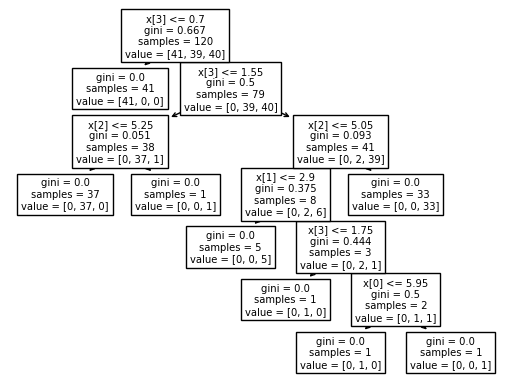

In [34]:
tree.plot_tree(clf2)
# This is a pretty neat way to visualize the tree 

In [35]:
#comparing our tree with inbuit tree:
y_pred=clf2.predict(X_test) 
accuracy_score(Y_test,y_pred)

0.9

In [ ]:
#Our tree seems a better model but that might not be true since there is a strong possibility that we have overfitted to this data

In [46]:
class MyRandomForest():
    def __init__(self, num_trees, max_depth=3):
        self.num_trees = num_trees
        self.max_depth = max_depth
        
        self.trees = []
        for _ in range(num_trees):
            self.trees.append(_DecisionTreeClassifier( self.max_depth))
                
    def get_random_subsets(self, X, y, num_subsets):
        num_samples = np.shape(X)[0]

        X_y = np.concatenate((X, y.reshape((1, len(y))).T), axis=1)
        np.random.shuffle(X_y)

        subsets = []
        subsample_size = int(num_samples // 2)

        for _ in range(num_subsets):
            index = np.random.choice(
                range(num_samples),
                size=np.shape(range(subsample_size)),
                replace=True)

            X = X_y[index][:, :-1]
            y = X_y[index][:, -1]

            subsets.append([X, y])

        return subsets        
        
    def fit(self, X, y):
        num_features = np.shape(X)[1]
        subsets = self.get_random_subsets(X, y, self.num_trees)

        for i in range(self.num_trees):
            X_subset, y_subset = subsets[i]
                
            # Feature bagging
            idx = np.random.choice(range(num_features), size=num_features, replace=True)
            self.trees[i].feature_indices = idx
            X_subset = X_subset[:, idx]
            self.trees[i].fit(X_subset, y_subset.reshape(-1,1))
         
    
    def predict(self, X):
        y_preds = np.empty((X.shape[0], len(self.trees)))
                
        for i, tree in enumerate(self.trees):
            print(tree.feature_indices)
            idx = tree.feature_indices
            prediction = tree.predict(X.iloc[:, idx])
            y_preds[:, i] = prediction
            
        y_pred = []
        for sample_predictions in y_preds:
            y_pred.append(np.bincount(sample_predictions.astype('int')).argmax())
                
        return y_pred

In [55]:
rfc=MyRandomForest(36) #selecting 36 trees



In [56]:
rfc.fit(X_train,Y_train)

In [57]:
rfc.predict(X_test) #Shows the feature indices chosen per tree and the out put after majority voting

[0 2 1 0]
[2 3 1 0]
[2 1 3 2]
[3 1 3 2]
[3 1 2 3]
[3 2 2 2]
[0 3 0 1]
[2 1 2 0]
[1 1 3 0]
[0 3 3 2]
[3 1 1 1]
[0 1 1 2]
[2 3 2 2]
[0 3 0 2]
[0 1 3 0]
[1 3 3 3]
[3 3 3 2]
[1 3 0 2]
[0 0 1 0]
[3 0 3 3]
[0 0 1 0]
[3 0 2 2]
[0 0 0 1]
[2 2 2 0]
[3 0 2 0]
[1 0 1 0]
[2 2 1 0]
[3 0 1 1]
[3 3 2 0]
[1 3 2 1]
[2 0 0 2]
[3 0 2 1]
[3 2 0 2]
[1 2 1 1]
[2 3 0 2]
[3 3 0 0]


[1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 0,
 0,
 1,
 1,
 1,
 0,
 2,
 0,
 0,
 1,
 2,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1]

In [58]:
y_pred=rfc.predict(X_test)
accuracy_score(Y_test,y_pred)

[0 2 1 0]
[2 3 1 0]
[2 1 3 2]
[3 1 3 2]
[3 1 2 3]
[3 2 2 2]
[0 3 0 1]
[2 1 2 0]
[1 1 3 0]
[0 3 3 2]
[3 1 1 1]
[0 1 1 2]
[2 3 2 2]
[0 3 0 2]
[0 1 3 0]
[1 3 3 3]
[3 3 3 2]
[1 3 0 2]
[0 0 1 0]
[3 0 3 3]
[0 0 1 0]
[3 0 2 2]
[0 0 0 1]
[2 2 2 0]
[3 0 2 0]
[1 0 1 0]
[2 2 1 0]
[3 0 1 1]
[3 3 2 0]
[1 3 2 1]
[2 0 0 2]
[3 0 2 1]
[3 2 0 2]
[1 2 1 1]
[2 3 0 2]
[3 3 0 0]


0.8333333333333334

In [59]:
#0.9 not bad!
